# Pitfall Analysis

In this notebook we explain the shortcomings and strengths of various aggregation strategies.


In [ ]:
# Firstly, we import necessary packages
import numpy as np
import matplotlib.pyplot as plt

from aggrigator.uncertainty_maps import UncertaintyMap
from aggrigator.methods import AggregationMethods as am
from aggrigator.summary import AggregationSummary
from aggrigator.util import generate_disk_bdry_mask, generate_disk_mask

%load_ext autoreload
%autoreload 2

def plot(array, figsize=(5,5), grey=False):
    fig, ax = plt.subplots(figsize=figsize)
    cmap = 'gray' if grey else 'viridis'
    ax.imshow(array, cmap=cmap, vmin=0, vmax=1)
    ax.axis('off')
    plt.show()

def plot_color_legend():
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colorbar as cbar
    import matplotlib.colors as mcolors

    # Define colormap and normalization
    cmap = plt.get_cmap('viridis')
    norm = mcolors.Normalize(vmin=0, vmax=1)

    # Create figure and colorbar
    fig, ax = plt.subplots(figsize=(0.4, 8))
    fig.subplots_adjust(bottom=0.5)

    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation='vertical')

    # Set labels for min, max, and intermediate values
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0', '0.25', '0.5', '0.75', '1'])

    plt.show()


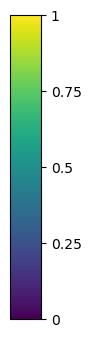

In [3]:
plot_color_legend()

## Mean

Mean cannot differ between images where:
- low uncertainty is spread across the image
- high uncertainty is located in a small fraction of the image.

Suggestion:
Including Standard Deviation as a measure can capture the variability of values.

Example:
Although the Mean is the same in below figure, we see a higher Std Dev where higher uncertainty values are attained.

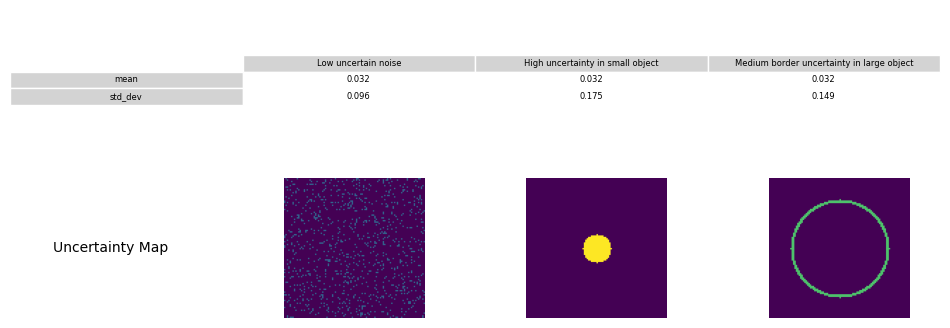

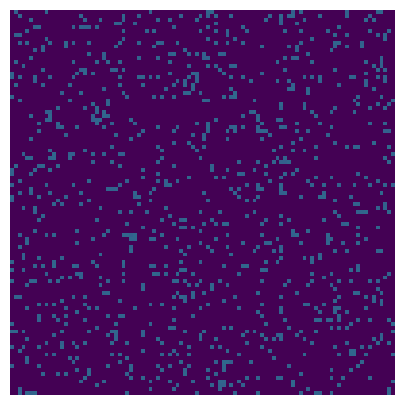

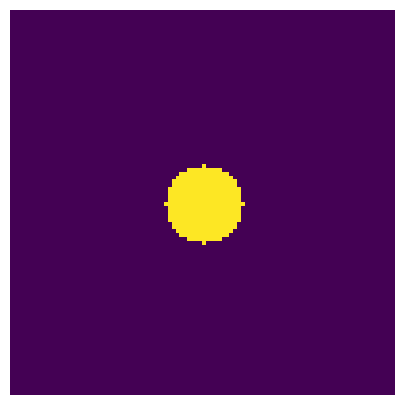

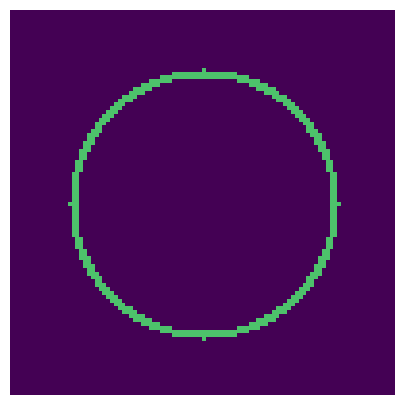

In [6]:
p = 0.9
array_1 = np.random.random((100,100))
array_1[array_1 < p] = 0
array_1*=0.34
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Low uncertain noise")

array_2 = generate_disk_mask((100,100), 10, (50,50))
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="High uncertainty in small object")

array_3 = generate_disk_bdry_mask((100,100), 35, (50,50), 2) * 0.72
unc_map_3 = UncertaintyMap(array=array_3, mask=None, name="Medium border uncertainty in large object")

summary = AggregationSummary([(am.mean, None), (am.std_dev, None)])
result = summary.apply_methods([unc_map_1, unc_map_2, unc_map_3], save_to_excel=False, do_plot=True, max_value=1.0)

plot(array_1)
plot(array_2)
plot(array_3)

## Patch-level Maximum

Patch-level maximum uses a sliding patch of a chosen size, averages the uncertainty values in that patch and returns the maximal average. This method includes pixelwise maximum for the choice of patch size = 1.

Downside is the choice of patch size which largely affects the resulting score:
- If patch size is chosen too small (e.g. 1 or 2) then method is prone to outliers
- If patch size is chosen larger than FG object size then the average will be much lower
- If uncertainty is mainly present in boundary then even choosing the patch size as object size results in low scores

In case of object focussed uncertainty Patch Aggregation can be used if size of present objects is known and approx. constant across the images. In that case choose patch size as object size.
In all other cases Patch Aggregation might result in lower scores than would be expected.

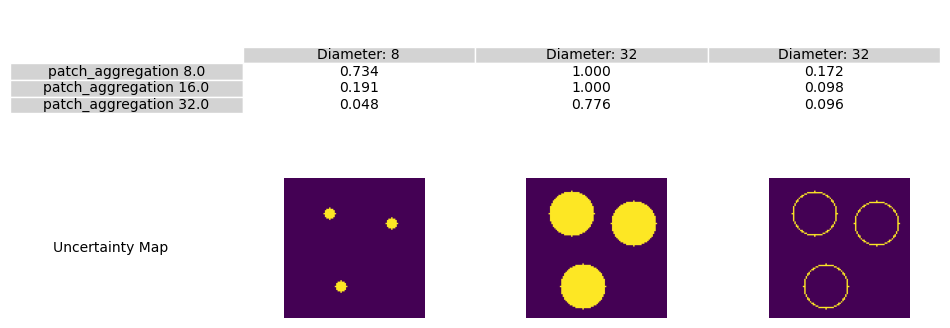

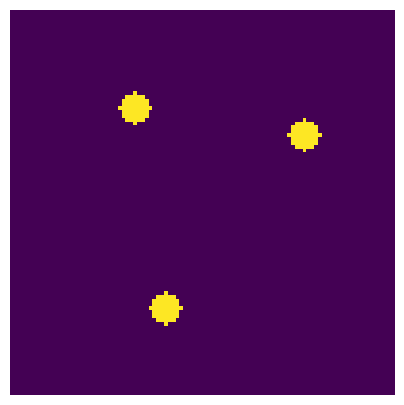

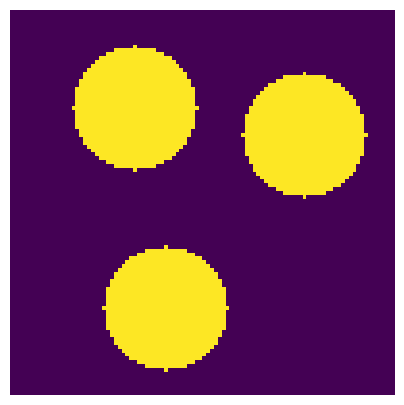

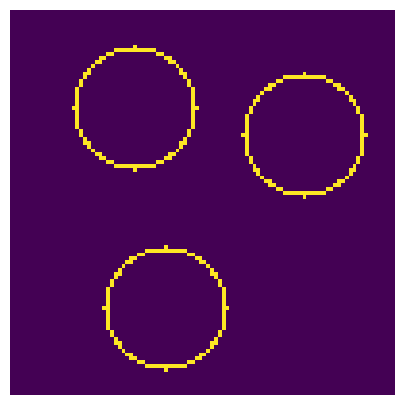

In [47]:
radius_1 = 4
array_1 = generate_disk_mask((100,100), radius_1, (32,76)) + generate_disk_mask((100,100), radius_1, (77,40)) + generate_disk_mask((100,100), radius_1, (25,32))
radius_2 = 16
array_2 = generate_disk_mask((100,100), radius_2, (32,76)) + generate_disk_mask((100,100), radius_2, (77,40)) + generate_disk_mask((100,100), radius_2, (25,32))
array_3 = generate_disk_bdry_mask((100,100), radius_2, (32,76), 1) + generate_disk_bdry_mask((100,100), radius_2, (77,40),1) + generate_disk_bdry_mask((100,100), radius_2, (25,32),1)
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Diameter: 8")
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="Diameter: 32")
unc_map_3 = UncertaintyMap(array=array_3, mask=None, name="Diameter: 32")

unc_maps = [unc_map_1, unc_map_2, unc_map_3]

#patch_sizes = [3, 6, 12, 24]
patch_sizes = [8, 16, 32]
summary = AggregationSummary([(am.patch_aggregation, s) for s in patch_sizes])
result = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True, max_value=1.0)

plot(array_1)
plot(array_2)
plot(array_3)

## Above-Threshold Mean

Above-Threshold Mean (ATM) is not "monotonous", i.e. it is possible that the ATM decreases even if all pixelwise uncertainty values increase.

Suggestion: Use Above-Quantile Mean instead, which is monotonous (yet has its own shortcomings). Do not use ATM to compare increases of uncertainty in an image, AQM is more reliable then.

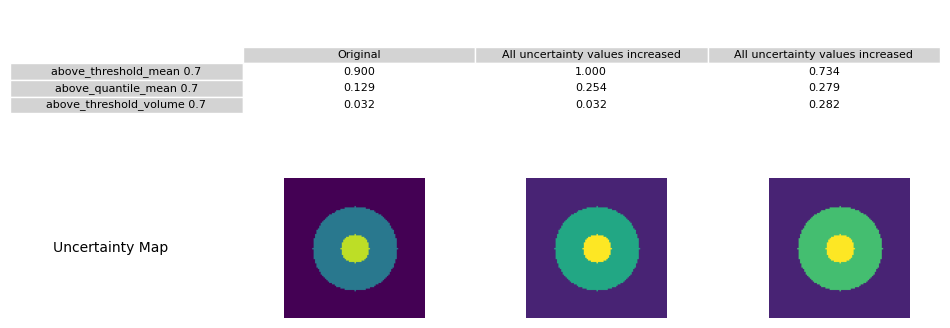

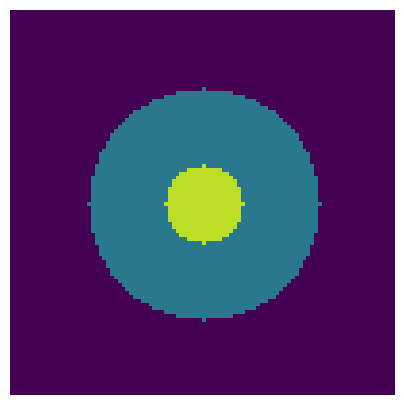

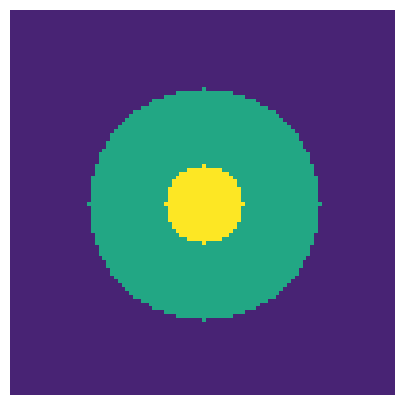

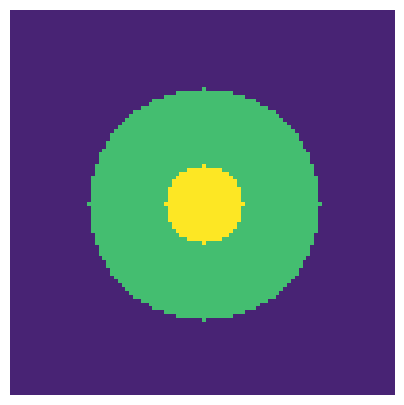

In [7]:
array_1 = generate_disk_mask((100,100), 30, (50,50))*0.4 + generate_disk_mask((100,100), 10, (50,50))*0.5
array_2 = 0.1 +generate_disk_mask((100,100), 30, (50,50))*0.5 + generate_disk_mask((100,100), 10, (50,50))*0.4
array_3 = 0.1 +generate_disk_mask((100,100), 30, (50,50))*0.6 + generate_disk_mask((100,100), 10, (50,50))*0.3
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Original")
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="All uncertainty values increased")
unc_map_3 = UncertaintyMap(array=array_3, mask=None, name="All uncertainty values increased")

summary = AggregationSummary([(am.above_threshold_mean, 0.7), (am.above_quantile_mean, 0.7), (am.above_threshold_volume, 0.7)])
result = summary.apply_methods([unc_map_1, unc_map_2, unc_map_3], save_to_excel=False, do_plot=True, max_value=1.0)

plot(array_1)
plot(array_2)
plot(array_3)

## Above-Quantile Mean

Above-Quantile Mean (AQM) may be problematic in case we want to compare uncertainty across images of different size. 

Suggestion:
- Do not use AQM to compare uncertainty of similar images with varying image sizes; ATM is more reliable then.
- More generally, if portion p of relevant pixels is known (e.g. FG ratio) then choose 1-p quantile.

Example: In the figure below is an uncertainty map of an object (left) and the exact same uncertainty map but cropped, removing "superfluous" background (right). Although the object-level uncertainty has not changed the AQM shows drastic changes. In this case ATM proves to be consistent to capture object uncertainty well.



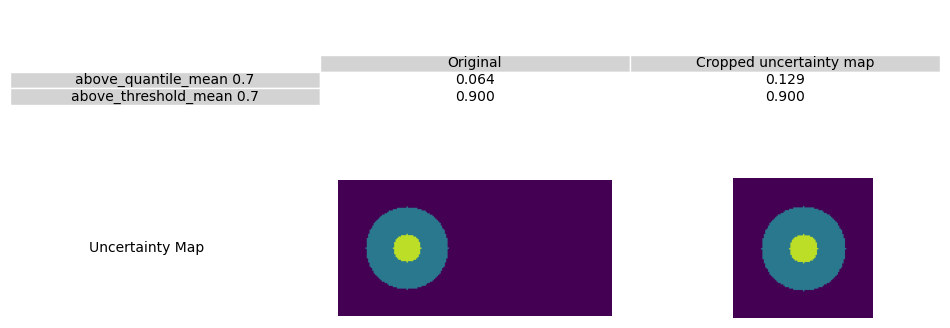

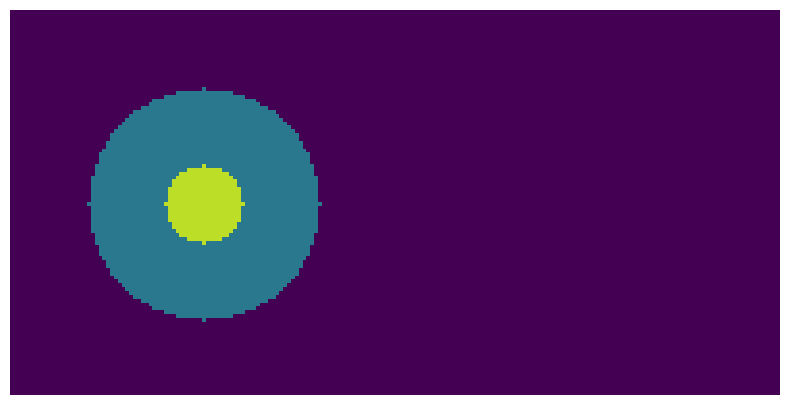

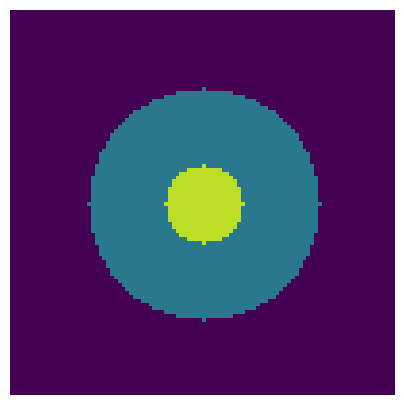

In [59]:
array_1 = np.zeros((100,200))
array_1[20:80,20:80] = 0.4
array_1[40:60,40:60] = 0.9
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Original")

array_2 = np.zeros((100,100))
array_2[20:80,20:80] = 0.4
array_2[40:60,40:60] = 0.9
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="Cropped uncertainty map")

array_1 = generate_disk_mask((100,200), 30, (50,50))*0.4 + generate_disk_mask((100,200), 10, (50,50))*0.5
array_2 = generate_disk_mask((100,100), 30, (50,50))*0.4 + generate_disk_mask((100,100), 10, (50,50))*0.5
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Original")
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="Cropped uncertainty map")

summary = AggregationSummary([(am.above_quantile_mean, 0.7), (am.above_threshold_mean, 0.7)])
result = summary.apply_methods([unc_map_1, unc_map_2], save_to_excel=False, do_plot=True, max_value=1.0)

plot(array_1, figsize=(10,5))
plot(array_2)

## Class-level Mean

Class-level Mean cannot quantify uncertainty well if it is mostly present on the boundary of an object - and the object diameter is large compared to the uncertainty band at the boundary (as is often the case in FG-BG or instance segmentations).

Suggestion: Class-level Mean is a good choice if the uncertainty is spread across the whole class ("Object Focussed Uncertainty"). In this case, the Class-level Mean is invariant to object scale and object count (assuming all objects of same class show a similar distribution of uncertainty). For "Boundary Focussed Uncertainty" use Boundary Mean.

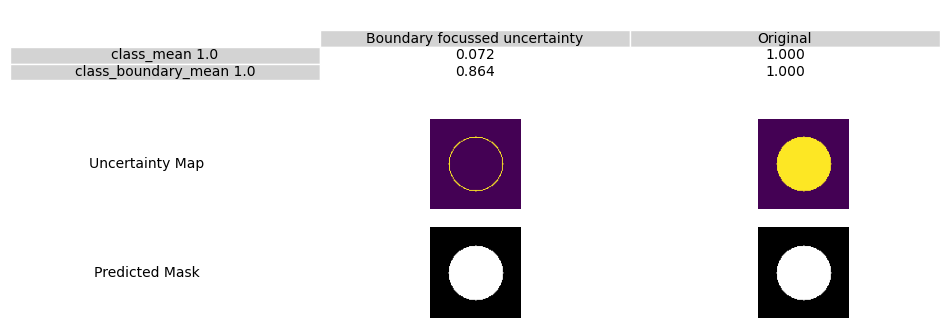

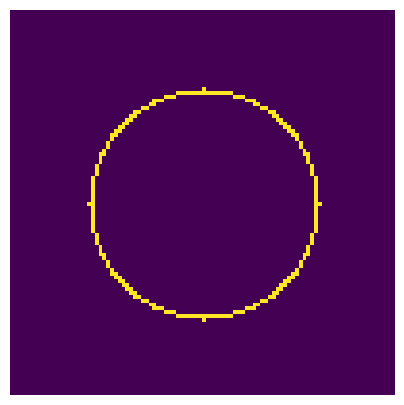

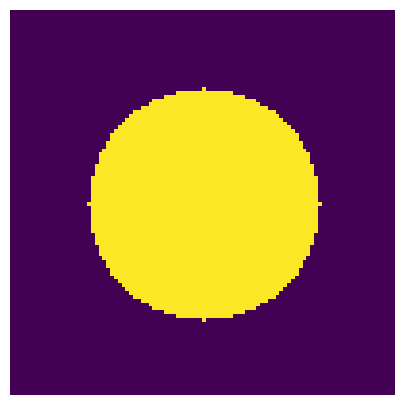

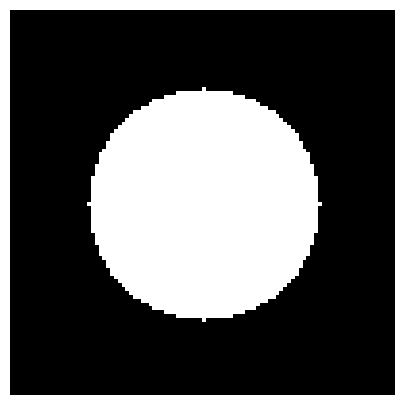

In [65]:
array_1 = generate_disk_bdry_mask((100,100), 30, (50,50), 1)
mask_1 = generate_disk_mask((100,100), 30, (50,50))
unc_map_1 = UncertaintyMap(array=array_1, mask=mask_1, name="Boundary focussed uncertainty")

array_2 = generate_disk_mask((100,100), 30, (50,50))
unc_map_2 = UncertaintyMap(array=array_2, mask=mask_1, name="Original")

summary = AggregationSummary([(am.class_mean, 1), (am.class_boundary_mean,1)])
result = summary.apply_methods([unc_map_1, unc_map_2], save_to_excel=False, do_plot=True, max_value=1.0)

plot(array_1)
plot(array_2)
plot(mask_1, grey=True)

## Class interior mean

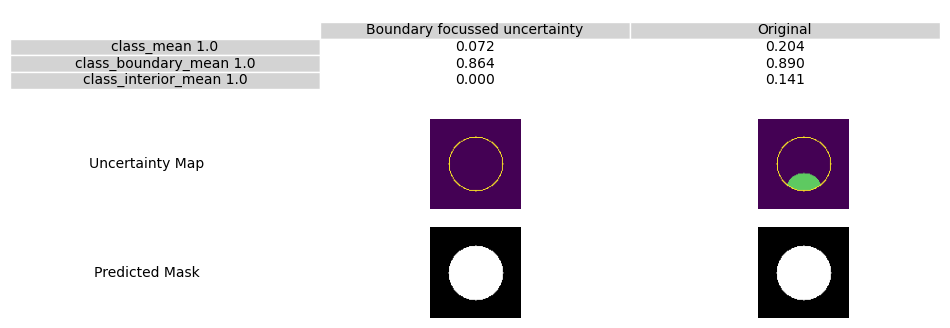

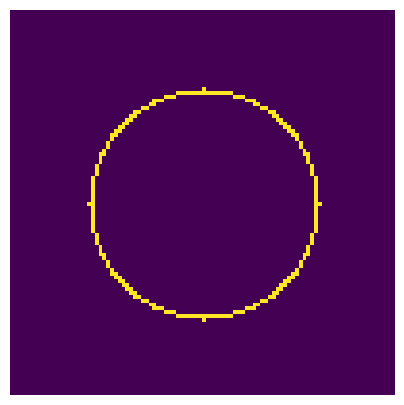

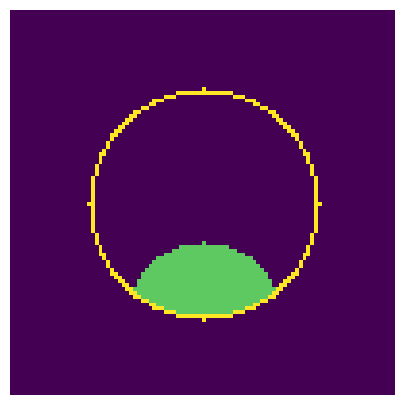

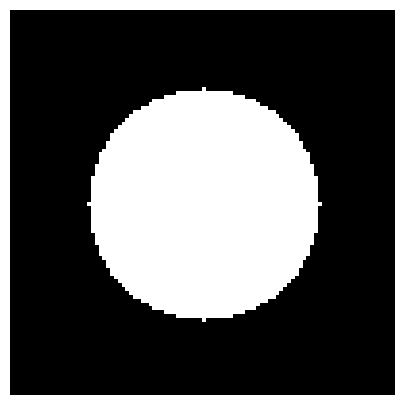

In [ ]:
array_1 = generate_disk_bdry_mask((100,100), 30, (50,50), 1)
mask_1 = generate_disk_mask((100,100), 30, (50,50))
unc_map_1 = UncertaintyMap(array=array_1, mask=mask_1, name="Boundary focussed uncertainty")

array_2 = generate_disk_bdry_mask((100,100), 30, (50,50), 1) + generate_disk_mask((100,100), 20, (80,50)) * 0.75
array_2 = np.minimum(array_2, 1.0)
# Set all pixels with radius larger 30 from 50 50 to 0
array_2 = array_2 - array_2 * np.logical_not(generate_disk_mask((100,100), 30, (50,50)))
unc_map_2 = UncertaintyMap(array=array_2, mask=mask_1, name="Original")

summary = AggregationSummary([(am.class_mean, 1), (am.class_boundary_mean,1), (am.class_interior_mean, 1)])
result = summary.apply_methods([unc_map_1, unc_map_2], save_to_excel=False, do_plot=True, max_value=1.0)

plot(array_1)
plot(array_2)
plot(mask_1, grey=True)

# TODO

## Scale invariance

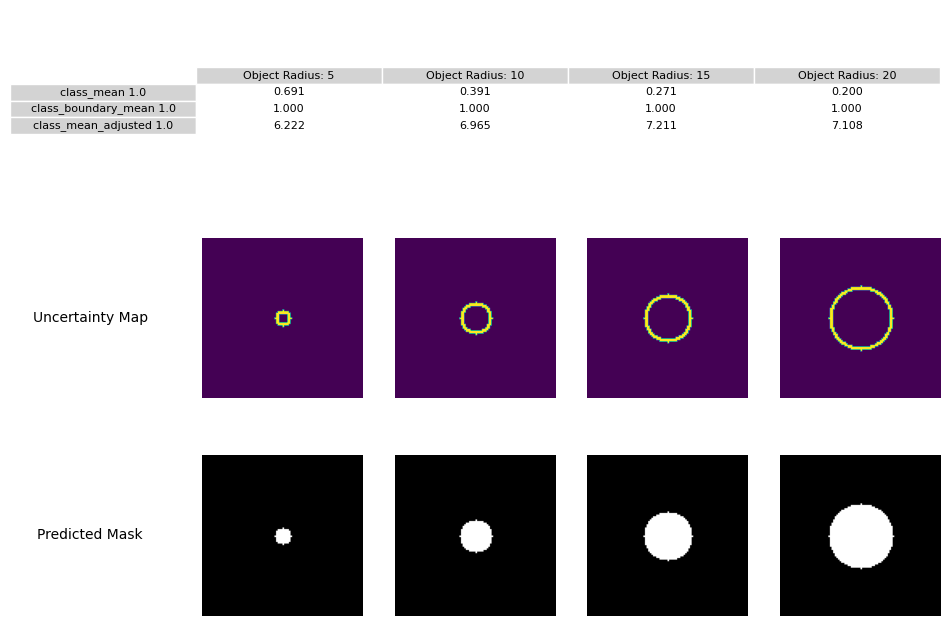

In [9]:
radii = [5, 10 , 15, 20]

arrays = [generate_disk_bdry_mask((100,100), r, (50,50), 2) for r in radii]
masks = [generate_disk_mask((100,100), r, (50,50)) for r in radii]
names = [f"Object Radius: {r}" for r in radii]
unc_maps = [UncertaintyMap(array=a, mask=m, name=n) for a, m, n in zip(arrays, masks, names)]

summary = AggregationSummary([(am.class_mean, 1), (am.class_boundary_mean,1), (am.class_mean_adjusted, 1)])
result = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True, max_value=1.0)

## Count invariance

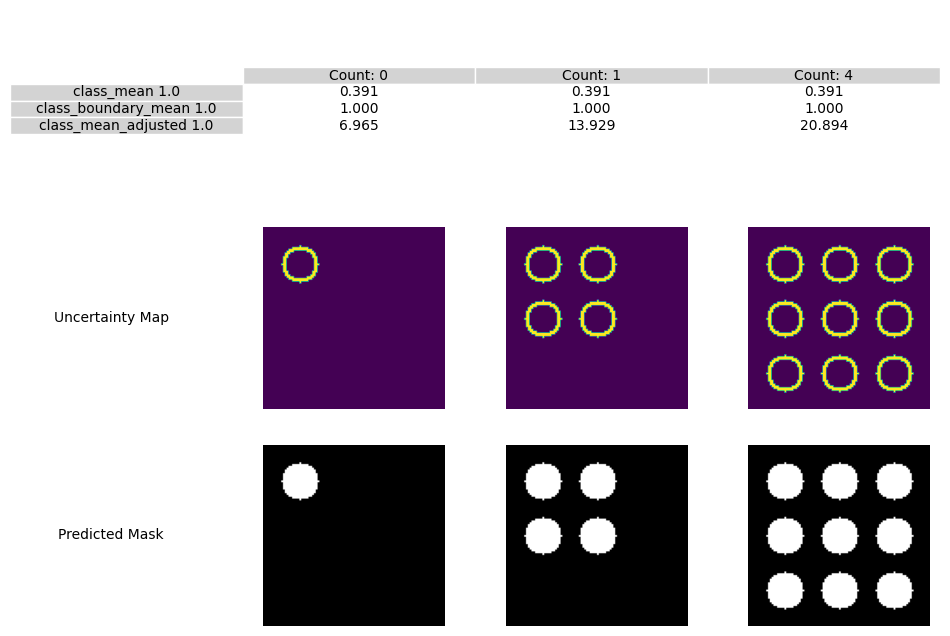

In [92]:
N = 3

def generate_obj_mask(N):
    mask = np.zeros((100,100))
    for i in range(N):
        for j in range(N):
            mask += generate_disk_mask((100,100), 10, (20 + 30*i,20 + 30*j))
    return mask

def generate_bdry_mask(N):
    mask = np.zeros((100,100))
    for i in range(N):
        for j in range(N):
            mask += generate_disk_bdry_mask((100,100), 10, (20 + 30*i,20 + 30*j), 2)
    return mask

arrays = [generate_bdry_mask(i+1) for i in range(N)]
masks = [generate_obj_mask(i+1) for i in range(N)]
names = [f"Count: {i**2}" for i in range(N)]
unc_maps = [UncertaintyMap(array=a, mask=m, name=n) for a, m, n in zip(arrays, masks, names)]

summary = AggregationSummary([(am.class_mean, 1), (am.class_boundary_mean,1), (am.class_mean_adjusted, 1)])
result = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=True, max_value=1.0)